# Chapter 1 Workbook

These are the solutions from [jdangerx](https://github.com/jdangerx/planetaryclimate) to the Chapter 1 problems of
[Principles of Planetary Climate](http://www.amazon.com/gp/product/0521865565/). 
No claims are made as to their accuracy, but if you are interested in
seeing what I've done go right ahead.

Python 3 compatible.

The datasets can be found [here](http://geosci.uchicago.edu/%7Ertp1/PrinciplesPlanetaryClimate/Data/dataPortal.html). Make sure that in the first line you adjust the directory where you have stored these data!

In [ ]:
dataDir = r'D:\Users\thomas\Coding\Python\climate\WorkbookDatasets'

First we have some imports and useful constants. Python doesn't have a
built-in sign function, so we have a simple implementation here
also. I've imported seaborn, which is an interesting graphing library
built on top of matplotlib. It does a lot of fancy things we don't
need, but importing it also makes all matplotlib graphs look nicer.

In [1]:
from math import e, log2, pi, log
from functools import partial

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.integrate import romb, quad, odeint
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.misc import derivative

import os


# gravitational constant
G = 6.67e-11

# mass of the earth
M_e = 6e24

# radius of earth, in m
r_earth = 6378100

# surface area of earth
sa_e = 4*pi*r_earth**2 

seconds_per_year = 60 * 60 * 24 * 365

#VSMOW
O18_p_O16 = 1/498.7  
D_p_H = 1/6420


def sign(x):
    try:
        return x/abs(x)
    except ZeroDivisionError:
        return 0
       

%matplotlib inline


### Problem 1.

This is pretty simple. We just need to plot a function. You can do
basic math on NumPy arrays, which is pretty sweet.

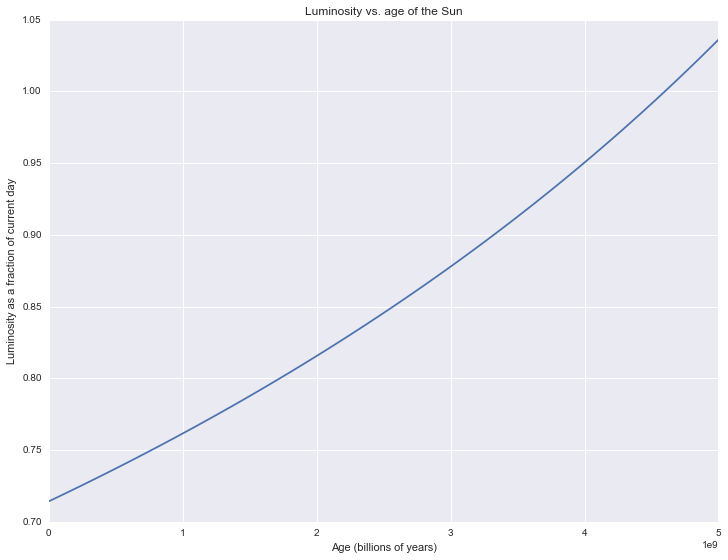

In [2]:
def luminosity(ages, t0=4.6e9):
    return (1 / (1 + 0.4 * (1 - ages/t0)))

def problem1():
    ages = np.linspace(0, 5e9, 100)
    luminosities = luminosity(ages)
    plt.figure(figsize=(12,9))
    plt.title("Luminosity vs. age of the Sun")
    plt.plot(ages, luminosities)
    plt.xlabel("Age (billions of years)")
    plt.ylabel("Luminosity as a fraction of current day")

problem1()


### Problem 2.

What was initially just a simple file IO example was complicated by
some interesting encoding issues. The Vostok ice core data was
unreadable with UTF-8. So I opened the file in Firefox - some of the
scientists' names were rendered improperly. I played with the encoding
until it worked - unfortunately it was just listed in Firefox as
"Western." I then looked up what possible encodings I could use and
used the one labeled "Western Europe."

Additionally the C CSV parsing engine was having issues using the
`delim_whitespace` option, so I had to specify the Python engine
instead. Fortunately this dataset was pretty small (about 3000 lines)
so the speed hit wasn't really important.

I thought that having a line connecting the data points hid the
decrease in data density as ice age increases, so I made it with
points instead.


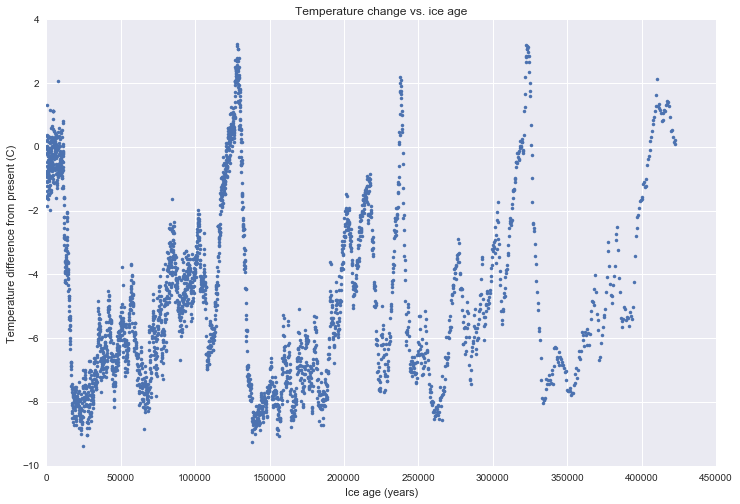

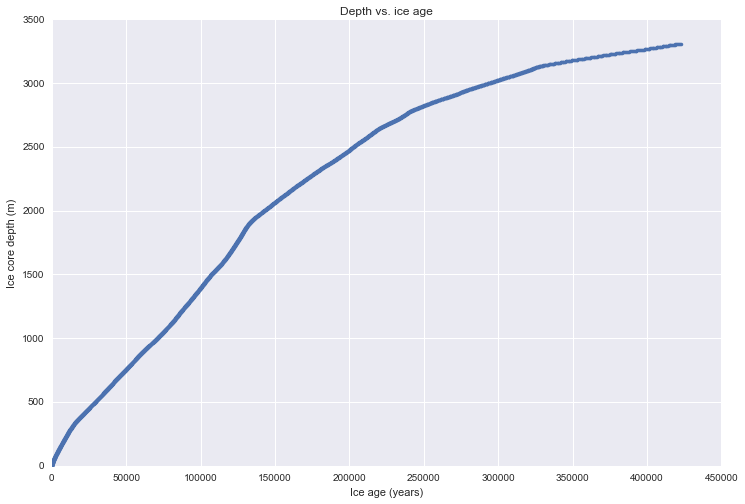

In [10]:
def problem2():
    vostokT = pd.read_csv(os.path.join(dataDir, r'Chapter1Data\iceCores\vostokT.txt'),
                          skiprows=115, 
                          encoding='iso8859_15', # "Western" encoding
                          delimiter='\s',
                          engine="python")
    plt.figure(figsize=(12,8))
    plt.title("Temperature change vs. ice age")
    plt.plot(vostokT.corrected_Ice_age_GT4, vostokT.deltaTS,
             marker=".", linestyle="none")
    plt.xlabel("Ice age (years)")
    plt.ylabel("Temperature difference from present (C)")
    plt.figure(figsize=(12,8))
    plt.title("Depth vs. ice age")
    plt.plot(vostokT.corrected_Ice_age_GT4, vostokT.Depth,
             marker=".", linestyle="none")
    plt.xlabel("Ice age (years)")
    plt.ylabel("Ice core depth (m)")
problem2()


### Problem 3.

This was an exercise in doing arithmetic on columns of data. I wanted
to try the Pandas DataFrames out. In this example I'm just using them
as a dict to store NumPy arrays, but there's a bunch of other cool
stuff they can do. Later I find the standard deviation of a column
with a method call on the DataFrame, which is pretty slick.

The first plot is pretty silly but it is a nice example of how to do
arithmetic on arrays.


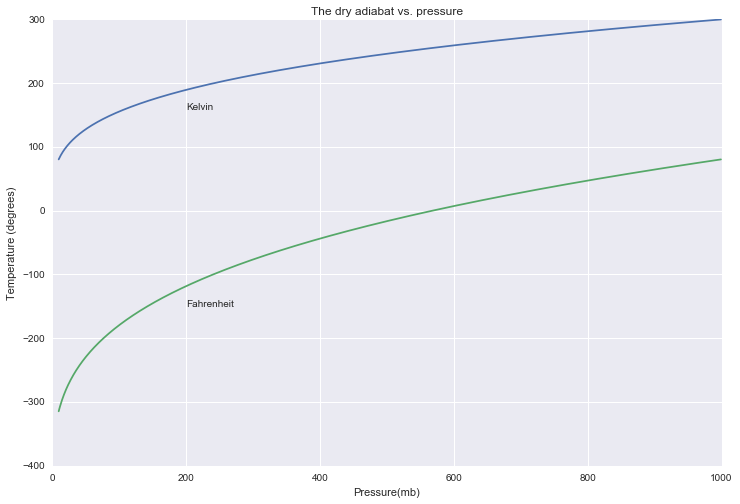

In [8]:
def dry_adiabat(pressures):
    ground_temp = 300
    surface_pressure = 1000
    return ground_temp * (pressures/surface_pressure) ** (2/7)


def K_to_F(kelvins):
    return (kelvins - 273) * 1.8 + 32


def problem3a():
    pressures = np.arange(10, 1000)
    df = pd.DataFrame({"pressures": pressures,
          "dry_adiabat_K": dry_adiabat(pressures),
          "dry_adiabat_F": K_to_F(dry_adiabat(pressures))})
    plt.figure(figsize=(12,8))
    plt.title("The dry adiabat vs. pressure")
    plt.ylabel("Temperature (degrees)")
    plt.xlabel("Pressure(mb)")
    plt.plot(df.pressures, df.dry_adiabat_K)
    plt.text(200, 160, "Kelvin")
    plt.plot(df.pressures, df.dry_adiabat_F)
    plt.text(200, -150, "Fahrenheit")


problem3a()


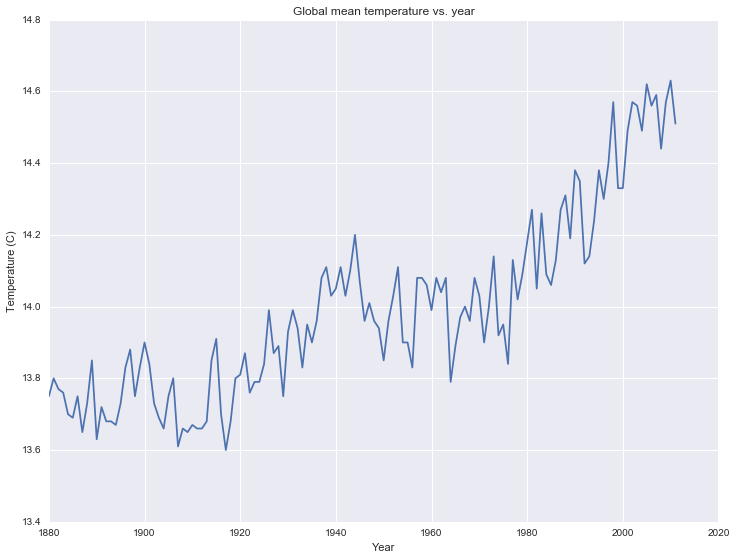

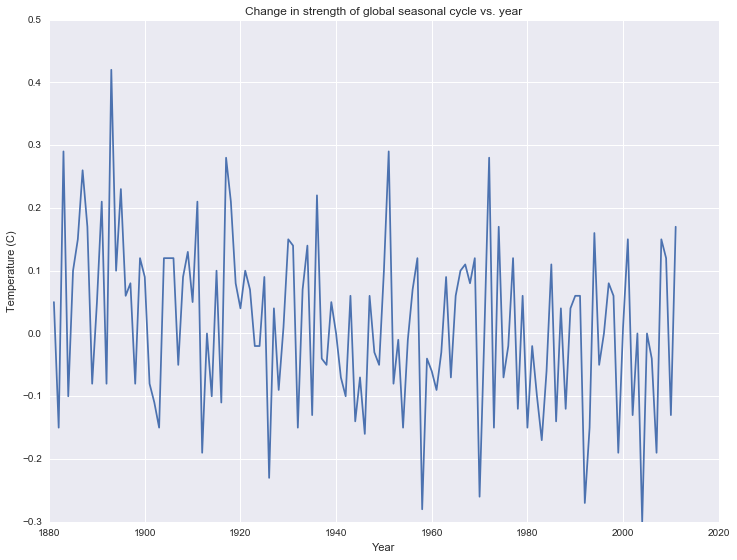

In [19]:
def problem3b():
    gisstemp = pd.read_csv(os.path.join(dataDir, r'Chapter1Data\GlobalWarming\GISSTemp.txt'),
                           skiprows=26,
                           header=1,
                           encoding="utf-8",
                           na_values="*****",
                           delim_whitespace=True)
    avg_temps = gisstemp["J-D"]/100 + 14
    season_diffs = (gisstemp.JJA - gisstemp.DJF)/100
    plt.figure(figsize=(12,9))
    plt.title("Global mean temperature vs. year")
    plt.xlabel("Year")
    plt.ylabel("Temperature (C)")
    plt.plot(gisstemp.Year, avg_temps)
    plt.figure(figsize=(12,9))
    plt.title("Change in strength of global seasonal cycle vs. year")
    plt.xlabel("Year")
    plt.ylabel("Temperature (C)")
    plt.plot(gisstemp.Year, season_diffs)

problem3b()

The temperature vs. year plot seems pretty reasonable. You get annual
fluctuations, and you see an upward trend that wouldn't be out of
place in a startup pitch deck.

The strength of the seasonal cycle seems to vary year-to-year as
well. There might be a slight downward trend - perhaps the southern
hemisphere winters are getting warmer? I think the variation is too
great to see a trend this small, but we could do some real analysis on
it if we wanted to dive deeper.


### Problem 4.

Instead of writing my own polynomial interpolation function, I used
one out of SciPy. I found that
`scipy.interpolate.InterpolatedUnivariateSpline` is significantly
faster than `scipy.interpolate.interp1d`.

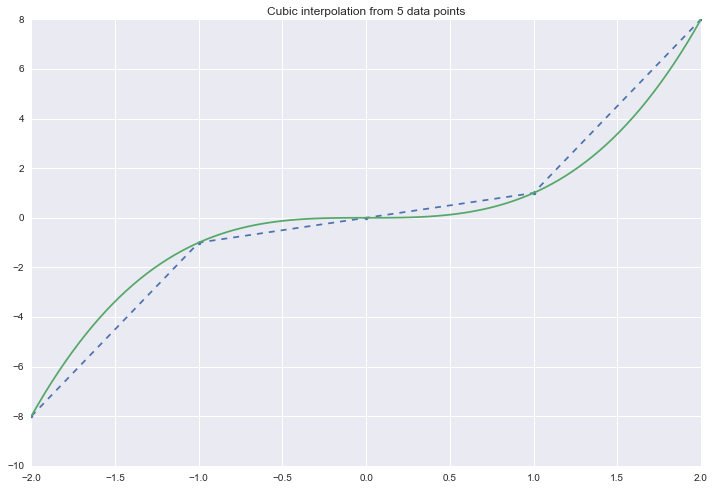

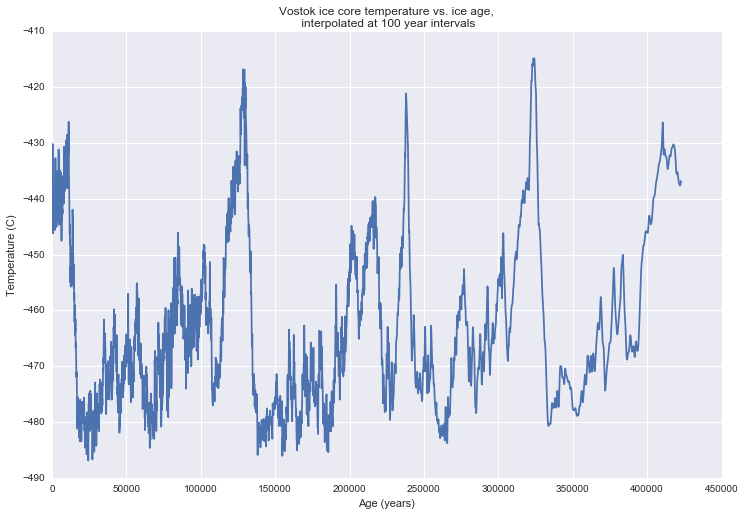

In [20]:
def problem4():
    cubic = pd.DataFrame({"x": [i for i in range(-2,3)],
                          "y": [i**3 for i in range(-2, 3)]})
    interp_cubic = InterpolatedUnivariateSpline(cubic.x, cubic.y, k=3)
    xspace = np.linspace(min(cubic.x), max(cubic.x), 100)
    interp_cubic_df = pd.DataFrame({"x": xspace,
                                    "y": interp_cubic(xspace)})
    plt.figure(figsize=(12, 8))
    plt.title("Cubic interpolation from 5 data points")
    plt.plot(cubic.x, cubic.y, marker=".", linestyle="dashed")
    plt.plot(interp_cubic_df.x, interp_cubic_df.y)

    vostokT = pd.read_csv(os.path.join(dataDir, r'Chapter1Data\iceCores\vostokT.txt'),
                          skiprows=115, 
                          encoding='iso8859_15', # "Western" encoding
                          delimiter='\s',
                          engine="python")
    
    interp_deut = InterpolatedUnivariateSpline(vostokT.corrected_Ice_age_GT4, vostokT.deut)
    hundred_yr_intervals = np.arange(min(vostokT.corrected_Ice_age_GT4),
                                     max(vostokT.corrected_Ice_age_GT4),
                                     100)
    plt.figure(figsize=(12, 8))
    plt.title("Vostok ice core temperature vs. ice age,\n interpolated at 100 year intervals")
    plt.xlabel("Age (years)")
    plt.ylabel("Temperature (C)")
    plt.plot(hundred_yr_intervals, interp_deut(hundred_yr_intervals))
               
problem4()


### Problem 5

This is where we use `sign`! This problem just asked to write some
root-finding algorithms. We see that Newton's method takes way fewer
steps to converge than the bisection method does -- 3 compared to 28.

In [21]:
def func5(x):
    return x - e**(-x)


def bisect(interval, fn, iters=0, tol=1e-8):
    xbds = [interval[0], sum(interval)/2, interval[1]]
    while xbds[2] - xbds[0] > xbds[1] * tol:
        iters += 1
        low, mid, hi = [fn(x) for x in xbds]
        if sign(low) == sign(hi):
            return None
        if sign(low) == sign(mid):
            xbds[0] = xbds[1]
        else:
            xbds[2] = xbds[1]
        xbds[1] = (xbds[0]+xbds[2])/2
    return (xbds[1], iters)


def newton(x0, fn, iters = 0, tol=1e-8, dx=1e-5):
    x1 = x0 - fn(x0)/derivative(fn, x0, dx=dx)
    while abs(x1 - x0) > 1e-8:
        iters += 1
        x0 = x1
        x1 = x0 - fn(x0)/derivative(fn, x0, dx=dx)
    return ((x1 + x0)/2, iters)
            
        
def problem5():
    print(bisect((0, 1), func5))
    print(newton(0.5, func5))

problem5()

(0.5671432893723249, 28)
(0.56714329040978251, 3)


### Problem 6.

I learned how to use the Romberg integration function,
`scipy.integrate.romb`! You need to make sure the number of samples is
one more than a power of two, so that's what the funky `ceil(log2(a))`
stuff is. Beyond that this is pretty straightforward. As expected, the
integral goes to 1 pretty quickly as a increases.

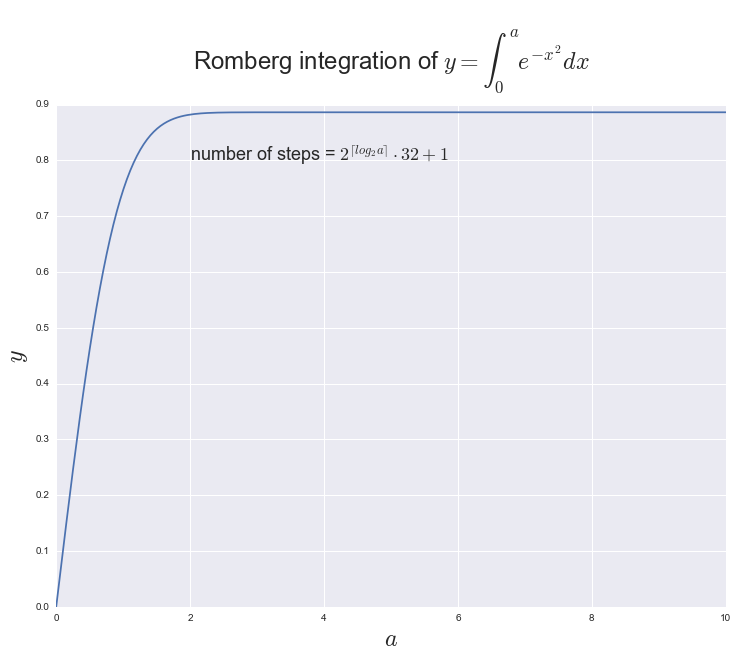

In [22]:
def gaussian(x):
    return e ** (-x**2)


def problem6():
    plt.figure(figsize=(12,9))
    aspace = np.linspace(0, 10, 200)
    plt.title("Romberg integration of $y=\int_0^ae^{-x^2}dx$\n", fontsize=24)
    plt.ylabel("$y$", fontsize=24)
    plt.plot(aspace, [romb_of_a(a) for a in aspace])
    plt.text(2, 0.8, r"number of steps = $2^{\lceil log_2 a\rceil}\cdot32+1$", fontsize=18)
    plt.xlabel("$a$", fontsize=24)


def romb_of_a(a):
    if a == 0:
        return 0
    xspace = np.linspace(0, a, 2**(5 + np.ceil(log2(a)))+1)
    return romb(gaussian(xspace), xspace[1] -xspace[0])


problem6()

### Problem 7

Instead of working hard and thinking about different numerical methods
for solving differential equations I just used `scipy.integrate.odeint`.


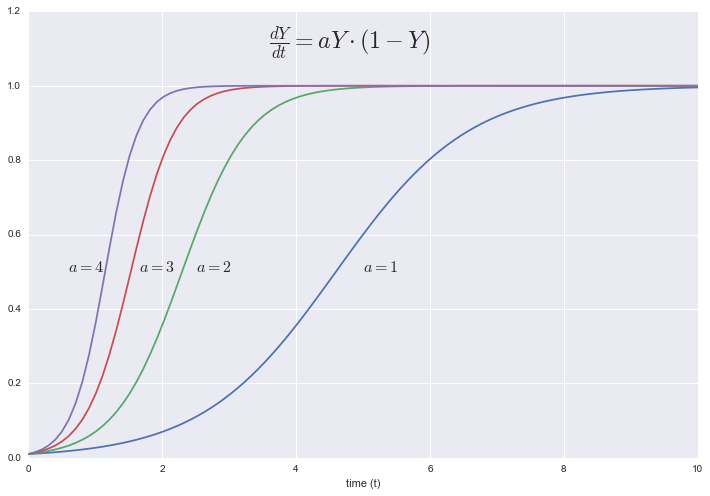

In [23]:
def diff_eq(a):
    return (lambda y, t: a*y*(1-y))

def problem7():
    tscale = np.linspace(0, 10, 100)
    plt.figure(figsize=(12, 8))
    plt.text(3.6, 1.1, r"$\frac{dY}{dt} = aY\cdot(1-Y)$", fontsize=24)
    plt.plot(tscale, odeint(diff_eq(1), 0.01, tscale))
    plt.text(5, 0.5, r"$a=1$", fontsize=16)
    plt.plot(tscale, odeint(diff_eq(2), 0.01, tscale))
    plt.text(2.5, 0.5, r"$a=2$", fontsize=16)
    plt.plot(tscale, odeint(diff_eq(3), 0.01, tscale))
    plt.text(1.65, 0.5, r"$a=3$", fontsize=16)
    plt.plot(tscale, odeint(diff_eq(4), 0.01, tscale))
    plt.text(0.6, 0.5, r"$a=4$", fontsize=16)
    plt.xlabel("time (t)")

problem7()


### Problem 8.

Here I use a [cool trick from the SciPy
cookbook](http://wiki.scipy.org/Cookbook/Zombie_Apocalypse_ODEINT) by
turning two differential equations into one differential equation
which acts on a 2D vector, making it really easy to pitch to `odeint`.

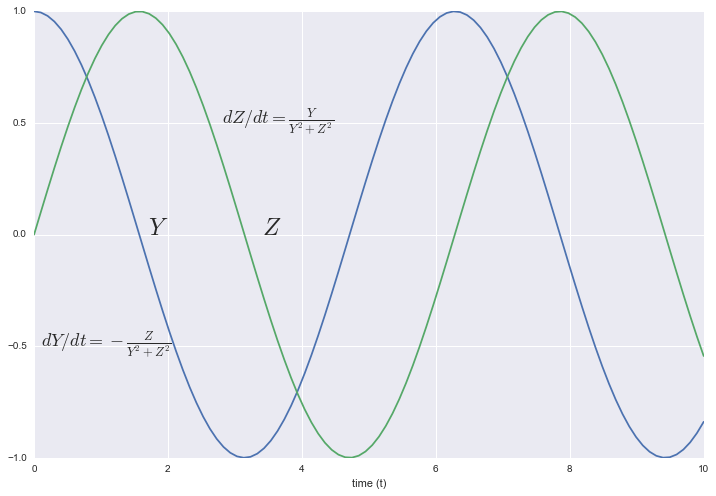

In [24]:
def func8(xs, t):
    y = xs[0]
    z = xs[1]
    fy = - z/(y**2 + z**2)
    fz = y/(y**2 + z**2)
    return [fy, fz]
    

def problem8():
    y0 = 1
    z0 = 0
    tscale = np.linspace(0, 10, 100)
    sol = odeint(func8, [y0, z0], tscale).transpose()
    plt.figure(figsize=(12, 8))
    plt.plot(tscale, sol[0])
    plt.text(1.7, 0, r"$Y$", fontsize=24)
    plt.text(0.1, -0.5, r"$dY/dt = -\frac{Z}{Y^2+Z^2}$", fontsize=18)
    plt.plot(tscale, sol[1])
    plt.text(3.4, 0, r"$Z$", fontsize=24)
    plt.text(2.8, 0.5, r"$dZ/dt = \frac{Y}{Y^2+Z^2}$", fontsize=18)
    plt.xlabel("time (t)")


problem8() 

### Problem 9.

Now begins a series of increasingly interesting basic physics and
chemistry problems.

In this one we calculate the amount of energy that comes into the
Earth from the Sun. We find that this is enough to raise our entire
atmosphere off the Earth pretty quickly. This hasn't happened yet
because a lot of the energy coming from the Sun ends up warming the
Earth. Then this energy just gets radiated out again. This leaves
little room for lifting our atmosphere. 

In [25]:
def grav_pot(r):
    "Get gravitational potential at a radius from the Earth."
    return -G*M_e/r

def problem9():
    weight = 10 # 10 m/s^2 * 1 kg = 10N
    print("The weight of a 1kg object on the surface of the Earth is "
          "10 newtons.")
    joules_per_kg_100m = 1000 # 10N * 100m = 1000J
    print("It takes 1000 joules to raise a 1kg mass 100m.")
    insolation = sa_e * 200
    print("The total insolation of the Earth is about {:.2e} watts.".format(
               insolation))
    delta_U = 1e4 * (grav_pot(2e5+r_earth) - grav_pot(r_earth)) # for 1 m^2
    
    num_sec = delta_U / 200
    print("It would take {:.2e} seconds, or {:.2f} years, to lift all parts "
          "of the atmosphere 200 km.".format(num_sec, num_sec/seconds_per_year))
    delta_U_mgh = 1e4 * 10 * 2e5
    num_sec_mgh = delta_U_mgh / 200

    print("If we assume that gravitational acceleration is independent of "
          "position we find that it would take {:.2f} years.".format(
              num_sec_mgh/seconds_per_year))

    
problem9()

The weight of a 1kg object on the surface of the Earth is 10 newtons.
It takes 1000 joules to raise a 1kg mass 100m.
The total insolation of the Earth is about 1.02e+17 watts.
It would take 9.54e+07 seconds, or 3.02 years, to lift all parts of the atmosphere 200 km.
If we assume that gravitational acceleration is independent of position we find that it would take 3.17 years.


### Problem 10.

A quick calculation of the kinetic energy of a comet with a mass of $4
\cdot 10^9$ kg and velocity of $1 \cdot 10^4$ m/s.

In [26]:
def problem10():
    # mv^2 / 2
    K = 4e9 * 1e4 ** 2 / 2
    print("The comet turns {} joules of kinetic energy into heat (and a little "
          "kinetic energy for the flying debris).".format(K))
problem10()
        

The comet turns 2e+17 joules of kinetic energy into heat (and a little kinetic energy for the flying debris).


### Problem 11.

We use Newton's law of gravitation to determine the mass of a body as
a function of its radius and surface gravitational
acceleration. Here's the derivation:

$$U = -\frac{GmM}{r}$$
$$\frac{\mathrm{d}U}{\mathrm{d}r} = \frac{GmM}{r^2} = ma$$
$$M = \frac{ar^2}{G}$$


In [27]:
def problem11():
    r_titan = 2.575e6
    a_titan = 1.35
    a_earth = 9.8
    mass_titan = r_titan**2 * a_titan / G
    mass_earth = r_earth**2 * a_earth / G
    print("The mass of Titan is {:.3} kg.".format(mass_titan))
    print("In comparison, the mass of Earth is {:.2} kg.".format(mass_earth))

problem11()

The mass of Titan is 1.34e+23 kg.
In comparison, the mass of Earth is 6e+24 kg.


### Problem 12.

A quick calculation of the potential energy of the Moon, and a
reminder that heavier things do not, in fact, fall faster. Could
Aristotle do this? I think not. 

In [28]:
def problem12():
    m_moon = 7.35e22
    r_moon = 3.84e8
    K_moon = U_moon = m_moon*(-1 * grav_pot(r_moon))
    print("The kinetic energy of the Moon on impact would be {:.2} J.".format(K_moon))
    v_f = (2*grav_pot(r_moon))**0.5
    print("The final velocity of the Moon is {:.2} m/s and does not depend on "
          "the mass of the Moon.".format(v_f))


problem12() 

The kinetic energy of the Moon on impact would be 7.7e+28 J.
The final velocity of the Moon is (8.8e-14+1.4e+03j) m/s and does not depend on the mass of the Moon.


### Problem 13.

If an impactor the size of the Moon hits the earth at 15,000 m/s, will
it vaporize?

Another gentle reminder that mass divides out all the time when you
are dealing with gravitational potential energy.

In [29]:
def problem13():
    m_moon = 7.35e22
    K_over_m = 0.5 * 1.5e4 ** 2  # 1/2 v^2
    K = m_moon * K_over_m
    vaporization_energy = 2e7
    print("The kinetic energy released by the impact is {:.2} J.".format(K))
    print("This is {:.2} J/kg.".format(K_over_m))
    if K_over_m < vaporization_energy:
        print("This is not enough to vaporize the impactor.")
    else:
        print("This is enough to vaporize the impactor.")


problem13() 

The kinetic energy released by the impact is 8.3e+30 J.
This is 1.1e+08 J/kg.
This is enough to vaporize the impactor.


### Problem 1.14.

We have 
$$M(\mathcal{L}_\circledast, d) = C-2.5\log_{10}\frac{\mathcal{L}_\circledast}{4\pi d^2}$$
where $M$ is bolometric magnitude, $L_\circledast$ is luminosity of a star, $d$ is the distance between that star and the observer, and $C$ a constant that makes the magnitude of Vega from Earth about 0.

Taking $r_0$ to be the average distance of the Earth from the Sun we have
$$M_0 = C - 2.5\log{10}\frac{\mathcal{L}_\odot}{4\pi r_0^2}$$
where $M_0$ is the bolometric magnitude of the Sun as seen from Earth.

Subtracting the two we get 
$$M_0 - M = 2.5 (\log{10} \frac{\mathcal{L}_\circledast}{4\pi d^2} -\log_{10} \frac{\mathcal{L}_\odot}{4\pi r_0^2})$$

$$\frac{M_0-M}{2.5} = \log_{10} \frac{\mathcal{L}_\circledast r_0^2}{\mathcal{L}_\odot d^2}$$
$$\mathcal{L}_\circledast = \mathcal{L}_\odot(\frac{d}{r_0})^2 10^{\frac{M_0-M}{2.5}}$$

Which makes sense - we see that as $M$ decreases, $\mathcal{L}_\circledast$ increases. All else held constant, lower bolometric magnitude should imply a more luminous star. Additionally the implied luminosty increases as $\frac{d}{r_0}$ increases if magnitude is held constant. We also see that the units are the same on both sides of the equation, which is an encouraging sign.
Now plugging the Gliese 581 numbers in, we get:

In [30]:
sun_lum = 3.846e26
M_0 = -26.82
r_0 = 1.496e11
m_per_parsec = 3.086e16


def bolometric(luminosity, dist):
    return -18.98 - 2.5*log(luminosity/(4*pi*dist**2), 10)
        

def lum_mag_dist(magnitude, dist):
    return sun_lum * (dist/r_0) **2 * 10**((M_0 - magnitude)/2.5)


def dist(magnitude, luminosity):
    return (luminosity * r_0**2 / sun_lum * 10**((magnitude - M_0)/2.5)) ** 0.5 


gliese_lum = lum_mag_dist(8.12, 6.27*m_per_parsec)
print("We need to be {:.2e} m from Gliese 581 for it to have the same apparent "
      "magnitude as the Sun on Earth.".format(dist(M_0, gliese_lum)))
print("We need to be {:.2e} m from the Sun for it to have the same apparent "
      "magnitude as the Sun on Earth.".format(dist(M_0, sun_lum)))
print("We need to be {:.2e} m from the Sun for it to have the same apparent "
      "magnitude as Gliese 581 from Earth.".format(dist(8.12, sun_lum)))
print("We need to be {:.2e} m from Gliese 581 for it to have the same apparent "
      "magnitude as Gliese 581 from Earth.".format(dist(8.12, gliese_lum)))


We need to be 1.99e+10 m from Gliese 581 for it to have the same apparent magnitude as the Sun on Earth.
We need to be 1.50e+11 m from the Sun for it to have the same apparent magnitude as the Sun on Earth.
We need to be 1.46e+18 m from the Sun for it to have the same apparent magnitude as Gliese 581 from Earth.
We need to be 1.93e+17 m from Gliese 581 for it to have the same apparent magnitude as Gliese 581 from Earth.


We would need to be orbiting at $1.99\times10^{10}$ m from Gliese 581
to get the same stellar flux as we do here on Earth.

Since flux varies as $r^2\mathcal{L}$, we could also have reached this
conclusion by finding the square root ratio of the luminosities and
multiplying that by Earth's orbital radius:

$$r = r_0\sqrt{\frac{\mathcal{L}_\circledast}{\mathcal{L}_\odot}}$$

Where $r$ is the orbital radius of a planet in the Gliese 581 system.

Incidentally, [Wikipedia](http://en.wikipedia.org/wiki/Gliese_581)
states that Gliese 581's apparent magnitude is between 10.56 and
10.58. Implications of this are left for the reader ;).

To find the absolute magnitude we just need to use the functions
defined above (or we can go straight to the flux):

In [31]:
def abs_mag(magnitude, dist):
    lum = lum_mag_dist(magnitude, dist)
    flux = lum/(4*pi*(10*m_per_parsec)**2)
    return -18.98 - 2.5 * log(flux, 10)
    
print("The absolute magnitude of the Sun is {:.2f}.".format(abs_mag(M_0, r_0)))
print("The absolute magnitude of Gliese 581 is {:.2f}."
      .format(abs_mag(8.12, 6.27*m_per_parsec)))

The absolute magnitude of the Sun is 4.75.
The absolute magnitude of Gliese 581 is 9.13.


The apparent magnitude of the Sun listed on Wikipedia is also slightly
higher than that found here.

### Problem 1.15

To find the hydrogen-burning lifetime of a star based on its
luminosity and mass, we first let $\mathcal{L}$ be luminosity, $E_f$
be energy per fusion, $m_f$ be mass per fusion, $M$ be mass of the
stellar core and $t_f$ be the time of final hydrogen fusion. Assuming
the star is completely hydrogen, we get:

$$M = \int_0^{t_f} \mathcal{L}\frac{m_f}{E_f}\mathrm{d}t$$.

If we assume $\mathcal{L}$ is constant, we get

$$M = \frac{\mathcal{L}m_f}{E_f}t$$
$$t = \frac{ME_f}{\mathcal{L}m_f}$$

However, we know that $\mathcal{L}$ actually varies with time, roughly
according to Eq. 1.1:

$$\mathcal{L}(t) = L_{t_\odot}(1+\frac{2}{5}(1-\frac{t}{t_\odot}))^{-1}$$

Which we can plug into the integral above:

$$M=\frac{\mathcal{L_\odot}m_f}{E_f}\int_0^{t_f}(1+\frac{2}{5}(1-\frac{t}{t_\odot}))^{-1}\mathrm{d}t$$

Let's take $t_\odot = \frac{t_f}{2}$, as recommended by the text -
this somewhat eases our minds about using this approximation far away
from $t_\odot$. After some $u$-substitution we can get

$$M=\frac{5\mathcal{L_\odot}m_ft_f}{4E_f}\ln\frac{7}{3}$$
$$t_f=\frac{4E_fM}{5\mathcal{L_\odot}m_f\ln\frac{7}{3}}$$

Now to answer the questions we just need to implement these equations
in code, keeping in mind that about 10% of the mass of a star actually
undergoes fusion.

Assuming constant luminosity of 4e26 W, a star with mass 2e30 kg has a lifetime of 9.9e+09 y.
Assuming variable luminosity of 4e26 W halfway through its Main Sequence, a star with mass 2e30 kg has a lifetime of 9.3e+09 y.


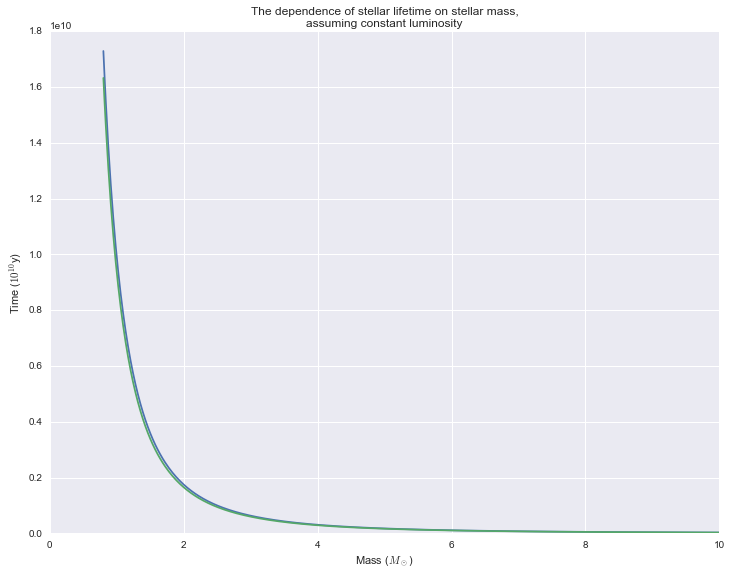

In [32]:
def mass_remaining(initmass, luminosity, time):
    "Luminosity needs to be a function taking time as a parameter."
    proton_mass = 1.67e-27
    mass_p_fusion = 4 * proton_mass
    energy_p_fusion = 4.17e-12
    burned = quad(luminosity, 0, time)[0] * mass_p_fusion / energy_p_fusion
    return initmass - burned


def findzero(func, init = 0, bd = 1):
    init_sign = sign(func(init))
    bd_sign = sign(func(bd))
    while init_sign == bd_sign:
        init = bd
        bd *= 2
        init_sign = sign(func(init))
        bd_sign = sign(func(bd))
    return bisect([init,bd], func)


def const_lum_lifetime(initmass=2e29, lum=4e26*seconds_per_year):
    return findzero(lambda t: mass_remaining(initmass,
                                             lambda t_l: lum,
                                             t))[0]

def var_lum_lifetime(initmass=2e29, lum=4e26*seconds_per_year):
    return findzero(lambda t_0: mass_remaining(initmass,
                                               lambda t_l: lum * luminosity(t_l, t_0),
                                               t_0 * 2),
                    init=1)[0]*2 
        

def problem15a():
    print("Assuming constant luminosity of 4e26 W, a star with mass 2e30 kg has a "
          "lifetime of {:.2} y.".format(const_lum_lifetime()))
    print("Assuming variable luminosity of 4e26 W halfway through its Main Sequence,"
          " a star with mass 2e30 kg has a lifetime of {:.2} y."
          .format(var_lum_lifetime()))
    mass_scale = np.linspace(0.8, 10, 500)  # ratio to solar mass
    plt.figure(figsize=(12,9))
    plt.plot(mass_scale, [const_lum_lifetime(initmass=m*2e29,
                                             lum=4e26*seconds_per_year*m**(3.5)) for m in mass_scale])
    plt.plot(mass_scale, [var_lum_lifetime(initmass=m*2e29,
                                           lum=4e26*seconds_per_year*m**(3.5)) for m in mass_scale])
    plt.title("The dependence of stellar lifetime on stellar mass,\n"
              "assuming constant luminosity")
    plt.xlabel("Mass ($M_\odot$)")
    plt.ylabel("Time ($10^{10}$y)")

problem15a()


We see that the radiation flux of the surface of a star is:

$$F_{out} = 5.67\cdot10^{-8}T^4$$

So the luminosity is given by

$$\mathcal{L} = F_{out}4\pi r^2 = 5.67cdot10^{-8}T^4\cdot4\pi r^2$$

And the surface temperature is given by

$$T=(\frac{\mathcal{L}}{5.67\cdot10^{-8}\cdot4\pi r^2})^{\frac{1}{4}}$$

Ignoring the compressibility of the star, its mass should vary as
$m = \frac{4}{3}\pi r^3 \Rightarrow r = (\frac{3m}{4})^{\frac{1}{3}} $.

So its temperature varies by

$$T=\Bigg(\frac{\mathcal{L}}{5.67\cdot10^{-8}\cdot4\pi (\frac{3M_\circledast}{4})^{\frac{2}{3}}}\Bigg)^{\frac{1}{4}}$$

Since $\mathcal{L} \propto M_\circledast^{3.5}$ (Eq 1.2) we have
                        
$$T=\Bigg(\frac{M_\circledast^{3.5}}{5.67\cdot10^{-8}\cdot4\pi (\frac{3M_\circledast}{4})^{\frac{2}{3}}}\Bigg)^{\frac{1}{4}}$$

And as $T$ increases we see that $M_\circledast$ must increase, which as we saw earlier, means that the lifetime of the star decreases.

### Problem 16.

What's the power density of the Sun compared to that of a human?

How much hydrogen would I need for my entire lifetime if we ran of fusion?

With a bit of simple math we can get a decent feel for these things.

In [33]:
def problem16():
    sun_lum = 3.84e26
    sun_core_mass = 1.99e29
    sun_power_density = sun_lum / sun_core_mass
    human_power = 1e2
    human_mass = 70
    human_power_density = human_power / human_mass
    print("A human uses about {:.2} watts/kg while the Sun uses {:.2} watts/kg."
          .format(human_power_density, sun_power_density))

    proton_mass = 1.67e-27
    mass_p_fusion = 4 * proton_mass
    energy_p_fusion = 4.17e-12
    energy_p_kg = energy_p_fusion / mass_p_fusion
    seconds_p_year = 365*24*60*60
    human_lifetime_energy = human_power * seconds_p_year * 80
    print("If a human ran on hydrogen fusion it would need {:.2} kg of hydrogen"
          " for a lifetime supply of energy."
          .format(human_lifetime_energy/energy_p_kg))

problem16()
        

A human uses about 1.4 watts/kg while the Sun uses 0.0019 watts/kg.
If a human ran on hydrogen fusion it would need 0.0004 kg of hydrogen for a lifetime supply of energy.


### Problem 17.

How much calcite does 1 Gt of carbon turn into? What kind of volume are we talking here?

In [34]:
def problem17():
    CaCO3_mass = 100.09
    C_mass = 12.01
    CaCO3_p_C = CaCO3_mass / C_mass
    area_KS = 2.13e5
    CaCO3_density = 2700 * 1e-12  # Gt/m^3
    print("Each Gt of C, turned into CaCO3, is {:.2} Gt.".format(CaCO3_p_C))
    print("This amount would cover Kansas in a layer {:.2} m thick."
          .format(CaCO3_p_C/CaCO3_density/area_KS))

problem17() 

Each Gt of C, turned into CaCO3, is 8.3 Gt.
This amount would cover Kansas in a layer 1.4e+04 m thick.


### Problem 18.

What does 9 Gt of additional carbon in the form of $\mathrm{CO}_2$
mean, in terms of molecule count and atmospheric concentration?

In [35]:
def problem18():
    CO2_mass = 44.01
    avogadro = 6.02e23
    C_mass = 12.01
    total_CO2_mass = CO2_mass / C_mass * 9e15 # 9 Gt of carbon in grams
    total_CO2_number = total_CO2_mass / CO2_mass * avogadro
    atmosphere_n = 1e44
    print("9 Gt carbon emissions is {:.2} CO2 molecules, which is {:.2}ppm."
          .format(total_CO2_number, total_CO2_number/atmosphere_n * 1e6))

problem18()
        

9 Gt carbon emissions is 4.5e+38 CO2 molecules, which is 4.5ppm.


### Problem 19.

Some basic $\delta$ calculations.

In [36]:
def problem19():
    return((1-0.037)*O18_p_O16,
           (1-0.438)*D_p_H)
problem19()


(0.0019310206536996193, 8.753894080996886e-05)

So we see that in ice with $\delta^{18}\mathrm{O}$ of -37 permil the
ratio of $^{18}\mathrm{O}$ to $^{16}\mathrm{O}$ is 0.0019.
We also see that in ice with $\delta\mathrm{D}$ of -438 permil the
ratio of $\mathrm{D}$ to $\mathrm{H}$ is $8.75\cdot10^{-5}$.

### Problem 20.    

What happens when you remove 300 m of the oceans' depth and freeze it
all in a glacier with $\delta\mathrm{D}$ of -420 permil?

$$(1+\delta_1)f_1+(1+\delta_2)f_2=1$$
$$\delta_2 = \frac{1-(1+\delta_1)f_1}{f_2} - 1$$

And $f_2 = 1-f_1$ so
$$\delta_2 = \frac{1-(1+\delta_1)f_1}{1-f_1} - 1$$

In [37]:
def problem20():
    ocean_vol = 1.4e18  # m^3
    ocean_sa = 3.6e14  # m^2
    removed_frac = 300 * ocean_sa / ocean_vol
    removed_dD = -0.42
    remaining_dD = (1-(1+removed_dD)*removed_frac)/(1-removed_frac) -1
    return remaining_dD

problem20()
        

0.03510835913312693

So if we removed 300 m depth of ocean water to form an Antarctic
glacier with $\delta\mathrm{D}$ of -420 permil this would increase the
$\delta\mathrm{D}$ of the ocean water by 35 permil.

### Problem 21.
We have 

$$r_1 = (1 + \epsilon) r_2$$

And for any $i$, with $r_s$ the isotopic ratio of some standard,

$$r_i = (1 + \delta_i) r_s$$

Plugging this in we get

$$(1+\delta_1)r_s = (1+\epsilon) (1+\delta_2) r_s$$
$$1+\delta_1 = 1 + \delta_2 + \epsilon\, (1 + \delta_2)$$
$$\delta_1 - \delta_2 = (1+\delta_2)\, \epsilon$$
$$\blacksquare$$


At 290 K the $\delta^{18}\mathrm{O}$ of water vapor in equilibrium with liquid with $\delta^{18}\mathrm{O}$ of 0 is -10 permil.
 
$$ \delta_1 - \delta_2 = (1+\delta_2)\, \epsilon $$
$$ \epsilon = -\frac{\delta_2}{1+\delta_2} $$

If we take phase 1 to be the liquid water and phase 2 to be the water vapor we have

$$ \epsilon = \frac{0.01}{0.99} = 0.010101... $$

If we take phase 2 to be liquid water and phase 1 to be the water vapor we have

$$ \epsilon = \frac{0.01}{1} = 0.01 $$

### Problem 22.

We know that 

$$\delta_0 = 0 = \delta_{vapor}f_{vapor} + \delta_{liquid}(1-f_{vapor})$$

$$\delta_{vapor}f_{vapor} = -\delta_{liquid}(1-f_{vapor})$$

Assuming the experiment occurs at 290K we can use $\delta_{vapor} = -0.01$. It is also stated in the problem that $f_{vapor} = 0.01$.

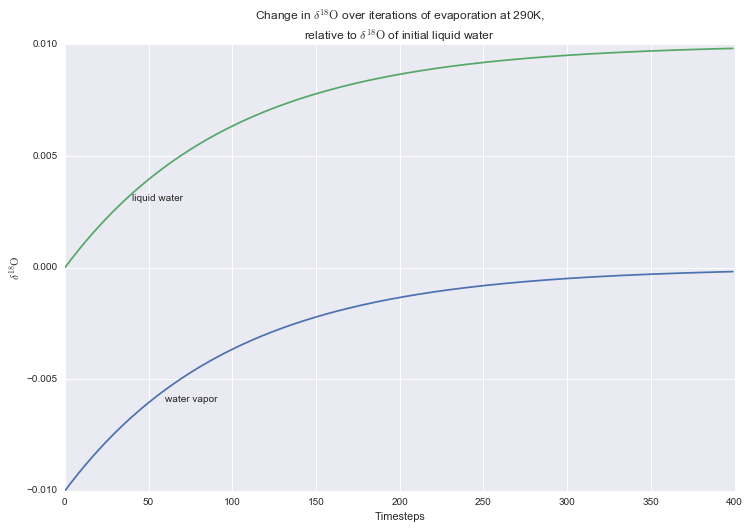

In [38]:
def d_source_of_t(epsilon, d_source_0, f_source, t):
    d_sources = d_source_0-epsilon*(1-f_source**t)
    return d_sources


def problem22():
    ntrials = 400
    f_source = 0.99
    d_source_0 = 0
    epsilon = -0.01
    evap = partial(d_source_of_t, epsilon, d_source_0, f_source)
    d_liqs = [evap(t) for t in range(ntrials)]
    d_vaps = [d_liq + epsilon for d_liq in d_liqs]
        
    plt.figure(figsize=(12,8))
    plt.title("Change in $\delta^{18}\mathrm{O}$ over iterations of evaporation at 290K,\n"
              "relative to $\delta^{18}\mathrm{O}$ of initial liquid water")
    plt.plot(range(ntrials), d_vaps)
    plt.plot(range(ntrials), d_liqs)
    plt.ylabel("$\delta^{18}\mathrm{O}$")
    plt.xlabel("Timesteps")
    plt.text(40, 0.003, "liquid water")
    plt.text(60, -0.006, "water vapor")
    
problem22()

We see that as time goes on the water vapor asymptotically approaches
0 permil relative to the initial liquid. This fits with our intuition
- as the liquid water all turns into water vapor, the water vapor
comes to represent all of the initial water. Additionally since less
and less water is changing phase in a given time period, the change in
isotopic composition also slows down as time goes on.

### Problem 23.

We have two lakes, separated by mountains. Water evaporates from the
first lake, goes over the mountain into the second lake. As the water
goes over the mountain some of it condenses out, so the water that
makes it to the second lake is lighter.

In part a, we calculate the magnitude of the preference. 

In part b, we see how this preference affects the
$\delta^{18}\mathrm{O}$ of the different lakes as a function of
transferred volume.

In part c, we add in a flow of water from the second lake to the first
lake to offset the evaporation from the first lake. We then see how
the system equilibrates.


After 50 timesteps the vapor's ratio of O18 is -13.89 permil relative to that of the lake.
After 75 timesteps the vapor's ratio of O18 is -15.25 permil relative to that of the lake.
0.003333277271129784 -0.010416491472280574 0.003659119816862611 -0.011434749427695661


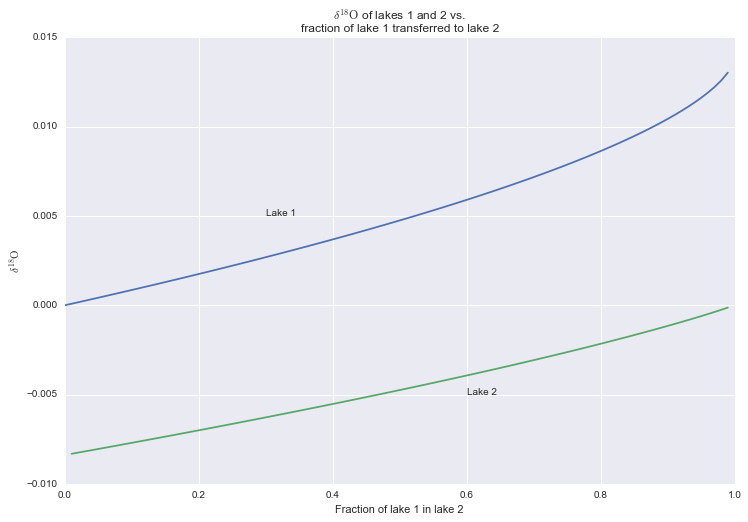

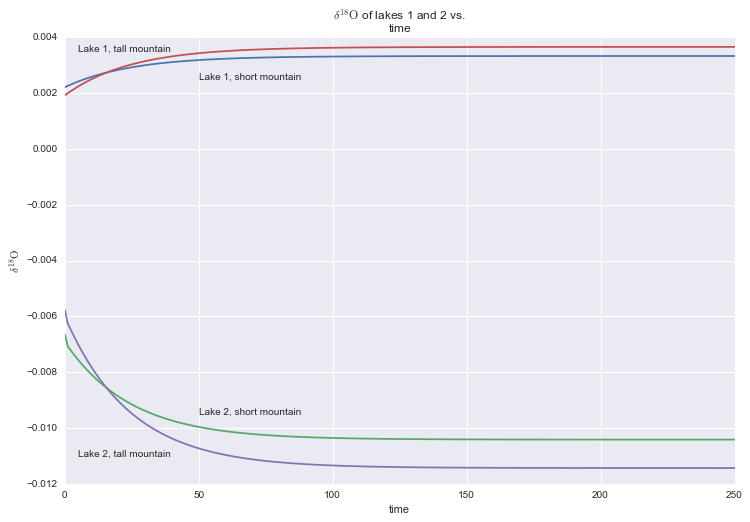

In [39]:
def d_source_of_frac(func, frac_gone, resolution=0.01):
    frac_remaining = 1 - frac_gone
    final_time = log(frac_remaining, (1-resolution))
    return func(final_time)


def d_target(d_source_0, d_source, source_remaining):
    return (d_source_0 - source_remaining*d_source) / (1-source_remaining)
        

def problem23a(ntrials, verbose=False):
    f_source = 0.99
    d_source_0 = -0.01
    epsilon = 0.01
    condense = partial(d_source_of_t, epsilon, d_source_0, f_source)
    d_vaps = [condense(t) for t in range(ntrials)]
    d_liqs = [d_vap + epsilon for d_vap in d_vaps]
    if verbose: 
        print("After {} timesteps the vapor's ratio of O18 is {:.2f} permil relative"
              " to that of the lake.".format(ntrials, d_vaps[-1]*1000))
    return d_vaps[-1]


def problem23b(mountain_steps, remaining_lake1 = 0.75, verbose=False):
    frac_evap = 0.01

    ntrials = 500
    f_lake2 = 0.99**mountain_steps * frac_evap
    f_lake1 = 1 - f_lake2
    f_source = f_lake1
    d_source_0 = 0
    epsilon = problem23a(mountain_steps, verbose=verbose)
    travel_over_mtn = partial(d_source_of_t, epsilon, d_source_0, f_source)
    # fracs is fractions of total that have been moved to lake2
    # thus 1-frac is the fraction remaining in lake1
    fracs = np.linspace(0, 0.99, 100)
    d_lake1s = [d_source_of_frac(travel_over_mtn, frac) for frac in fracs]
    d_lake2s = [d_target(d_source_0, d_lake1, 1-frac)
                for frac, d_lake1 in zip(fracs, d_lake1s)]

    d_lake1_25 = d_source_of_frac(travel_over_mtn, 1-remaining_lake1)
    d_lake2_25 = d_target(d_source_0, d_lake1_25, remaining_lake1)

    result = {"fracs": fracs,
              "d_lake1s": d_lake1s, 
              "d_lake2s": d_lake2s,
              "d_lake1_25": d_lake1_25,
              "d_lake2_25": d_lake2_25,
              "evap_epsilon": epsilon}
    return result

def problem23c(d_lake1_25, d_lake2_25, evap_epsilon, **kwargs):
    f_12 = 0.99  # prop. of lake 1 remaining after some goes to lake 2
    d_lake1s = [d_lake1_25]
    d_lake2s = [d_lake2_25]
    for n in range(250):
        d_lake1_n = d_source_of_t(evap_epsilon, d_lake1s[-1], f_12, 1)
        # now we know isotopic composition of lake2
        d_lake2_n = d_target(0, d_lake1_n, 0.75)
        # now we find the isotopic composition of lake1 which is basically
        # a weighted average
        d_lake1_n = f_12 * d_lake1_n + (1- f_12) * d_lake2_n
        d_lake1s.append(d_lake1_n)
        d_lake2s.append(d_lake2_n)

    return d_lake1s, d_lake2s


def problem23():
    lake_init_state_50 = problem23b(50, verbose=True)
    lake_init_state_75 = problem23b(75, verbose=True)

    plt.figure(figsize=(12,8))
    plt.plot(lake_init_state_50["fracs"], lake_init_state_50["d_lake1s"])
    plt.text(0.3, 0.005, "Lake 1")
    plt.plot(lake_init_state_50["fracs"], lake_init_state_50["d_lake2s"])
    plt.text(0.6, -0.005, "Lake 2")
    plt.title("$\delta^{18}\mathrm{O}$ of lakes 1 and 2 vs. \n"
              "fraction of lake 1 transferred to lake 2")
    plt.ylabel("$\delta^{18}\mathrm{O}$")
    plt.xlabel("Fraction of lake 1 in lake 2")

    d_lake1s_50, d_lake2s_50 = problem23c(**lake_init_state_50)
    d_lake1s_75, d_lake2s_75 = problem23c(**lake_init_state_75)

    plt.figure(figsize=(12,8))
    plt.plot(list(range(251)), d_lake1s_50)
    plt.text(50, 0.0025, "Lake 1, short mountain")
    plt.plot(list(range(251)), d_lake2s_50)
    plt.text(50, -0.0095, "Lake 2, short mountain")
    plt.plot(list(range(251)), d_lake1s_75)
    plt.text(5, 0.0035, "Lake 1, tall mountain")
    plt.plot(list(range(251)), d_lake2s_75)
    plt.text(5, -0.011, "Lake 2, tall mountain")
    plt.title("$\delta^{18}\mathrm{O}$ of lakes 1 and 2 vs. \n"
              "time")
    plt.ylabel("$\delta^{18}\mathrm{O}$")
    plt.xlabel("time")
    print(d_lake1s_50[-1], d_lake2s_50[-1], d_lake1s_75[-1], d_lake2s_75[-1])

        

problem23()

In the first graph, we see the isotopic ratio as a function of how
much water has moved from one lake to the other. We see that as more
and more water moves to lake 2 it becomes heavier and heavier,
approaching a $\delta^{18}\mathrm{O}$ of near zero. We also see that
the slopes of the lake 1 curve and the lake 2 curve start out
similarly, but diverge near the end as lake 1 dries up.

In the second graph, we see the isotopic ratio as a function of time
after lake 2 begins emptying. Here we have set lake 2 to empty when it
reaches 25% the volume of lake 1. We see that the
$\delta^{18}\mathrm{O}$ approaches about 3.3 permil for Lake 1 and
about -10.4 permil for Lake 2. This process is analogous to
transferring sea water to a glacier. We can think of lake 1 as the sea
water, and lake 2 as the glacier. If all of lake 2 freezes, its
isotopic composition is the same as if it was liquid, so we have the
effect in the first graph. Now if we have lake 2, the glacier, melt at
a rate so that the volume equilibrate when lake 2 has 25% of the total
volume, we get the effect in the second graph.

If we increase the mountain height we increase the difference between
lake 1 and the inflow into lake 2. This causes the equilibrium states
of lake 1 and lake 2 to shift apart, with lake 1 going up to about 3.7
permil and lake 2 going down to about -11.4 permil. This effect is
analogous to that of lowering the temperature of a glacier as both
increase the isotopic difference between the sea water and the newly
transferred glacier/lake 2 water.



### Problem 24.

Let's take $\delta_a$ to be the initial $\delta^{13}\mathrm{C}$ of the
atmosphere and $\delta_{in}$ to be that of the released carbon. Let's
also use $\delta_a'$ to denote the new $\delta^{13}\mathrm{C}$ of the
atmosphere after the influx of light carbon. Then we have

$$\delta_a' = f_a\delta_a + f_in \delta_{in}$$

Where $f_a$ is the fraction of the total carbon that was original, and
$f_{in}$ is the fraction that makes up the influx of carbon. Since
$f_a + f_{in} = 1$ we have

$$\delta_a' - \delta_a = f_in(\delta_{in} - \delta_a)$$

We can see that $\delta_a$ does have an effecct on $\delta_a' -
\delta_a$. This makes sense - if the atmospheric carbon was strangely
light this release of organic carbon would actually make the
atmospheric carbon heavier.

However, if we assume the atmosphere hasn't changed much since the
organic carbon was plants we can assume that the $\delta_{in}$ is -25
permil relative to $\delta_a$ and we can set $\delta_a=0$. So what
matters is really the relative difference between $\delta_{in}$ and
$\delta_a$.

In [40]:
def problem24(initcarbon, d_in, influx_amt = 700, d_a = 0):
    f_a = initcarbon / (700 + initcarbon)
    f_in = 700 / (700 + initcarbon)
    Dd = f_in * (d_in - d_a)
    print("When {} Gt of carbon with dC13 of {:.2f} permil is released into an atmosphere \n"
          "containing {} Gt carbon with dC13 of {:.2f} permil, the dC13 of the atmosphere \n"
          "changes by {:.2f} permil.".format(influx_amt,
                                         d_in*1000.,
                                         initcarbon,
                                         d_a*1000.,
                                         Dd*1000.))

problem24(700, -0.025)
problem24(1400, -0.025)
problem24(700, -0.050)
problem24(70000, -0.025, influx_amt=7000)
        

When 700 Gt of carbon with dC13 of -25.00 permil is released into an atmosphere 
containing 700 Gt carbon with dC13 of 0.00 permil, the dC13 of the atmosphere 
changes by -12.50 permil.
When 700 Gt of carbon with dC13 of -25.00 permil is released into an atmosphere 
containing 1400 Gt carbon with dC13 of 0.00 permil, the dC13 of the atmosphere 
changes by -8.33 permil.
When 700 Gt of carbon with dC13 of -50.00 permil is released into an atmosphere 
containing 700 Gt carbon with dC13 of 0.00 permil, the dC13 of the atmosphere 
changes by -25.00 permil.
When 7000 Gt of carbon with dC13 of -25.00 permil is released into an atmosphere 
containing 70000 Gt carbon with dC13 of 0.00 permil, the dC13 of the atmosphere 
changes by -0.25 permil.


We see that in our simulation of the PETM we have underestimated the
amount of lightening by a factor of five. Assuming the masses of the
carbon flows given in the book are not wildly inaccurate, this
difference must be mostly accounted for by the assumption that the
$\delta^{13}\mathrm{C}$ of carbonates in the ocean mirrors the shift
in $\delta^{13}\mathrm{C}$ of the entire carbon pool, and that the
carbon is distributed evenly throughout the carbon pool. For example,
if the lighter carbon was quickly absorbed into the oceans and
deposited, the carbonates would be lighter than the pool as a whole.


### Problem 25.

We look at an atmosphere that has a $\delta^{13}\mathrm{C}$ of -6
permil and introduce photosynthesis. We compare the effect of
photosynthesis without any additional outgassing to compensate for
organic burial to that of photosynthesis with outgassing.
    

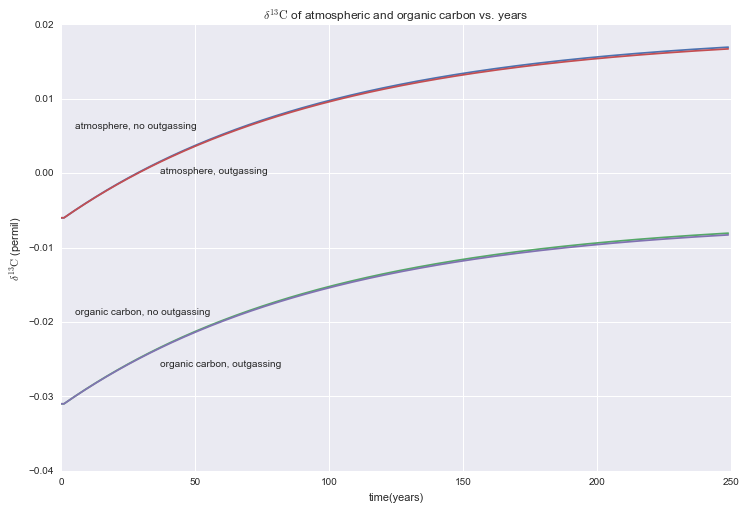

In [41]:
def problem25(outgas_rate, ntimesteps, photosynthesis_rate=0.01):
    # outgas rate as a fraction of initial atmospheric mass
    photosynthesis_rate = 0.01
    d_outgas = -0.006
    d_org = d_outgas - 0.025
    d_atms = [d_outgas]
    d_orgs = [d_org]
    for t in range(ntimesteps):
        d_atm_t = d_source_of_t(-0.025, d_outgas, 1 - photosynthesis_rate, t)
        #outgassing adjustment
        d = (1 - outgas_rate) * d_atm_t + outgas_rate * d_outgas
        d_atms.append(d)

        d_org_t = d_atms[-1] - 0.025
        d_orgs.append(d_org_t)
    return d_atms, d_orgs

timesteps = 250
d_atms_no_out, d_orgs_no_out = problem25(0, timesteps)
d_atms, d_orgs = problem25(0.01, timesteps, photosynthesis_rate=0.01)

plt.figure(figsize=(12, 8))
plt.title("$\delta^{13}\mathrm{C}$ of atmospheric and organic carbon vs. years")
plt.xlabel("time(years)")
plt.ylabel("$\delta^{13}\mathrm{C}$ (permil)")
plt.plot(range(timesteps), d_atms_no_out[:-1])
plt.text(5, 0.006, "atmosphere, no outgassing")
plt.plot(range(timesteps), d_orgs_no_out[:-1])
plt.text(5, -0.019, "organic carbon, no outgassing")
plt.plot(range(timesteps), d_atms[:-1])
plt.text(37, 0, "atmosphere, outgassing")
plt.plot(range(timesteps), d_orgs[:-1])
plt.text(37, -0.026, "organic carbon, outgassing")
    


If we were to take a core sample we would find a similar curve to
this, but it would be compressed into a log scale on the X
axis. because it takes longer to lay down a certain depth of organic
carbon as less and less carbon is being taken out of the atmosphere.

We see that the outgassing has only a slight downwards effect on the
photosynthesis effect as a whole. This isn't affected by the total
amount of carbon in the system - however, it is affected by the rate
of outgassing required. Higher burial rate

The mass of $\mathrm{O}_2$ in the atmosphere increases without bound
in the outgassing case. This does not happen because there are
critters like us that turn it back into CO2.


### Problem 26.

We have some benthic foram data that shows the historical levels of
$\delta^{13}\mathrm{C}$ and $\delta^{18}\mathrm{O}$. We would like to
see how this data matches up with the mechanisms we modeled in
problems 23 and 25.


d13C varied by 1.4 permil and the stddev was 0.24 permil.
d18O varied by 2.2 permil and the stddev was 0.38 permil.


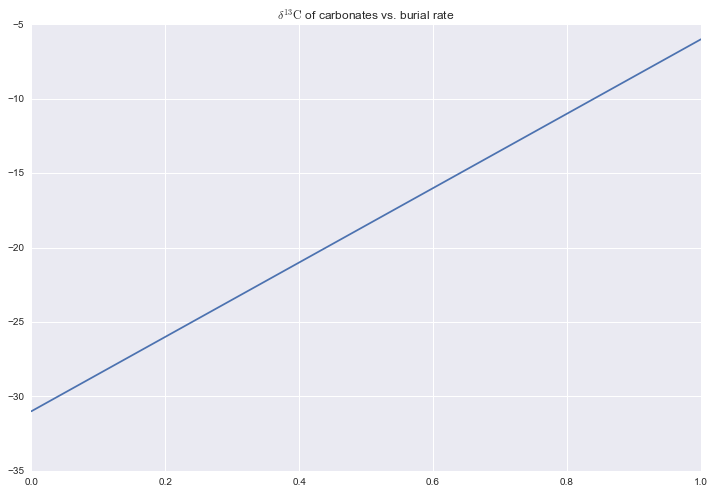

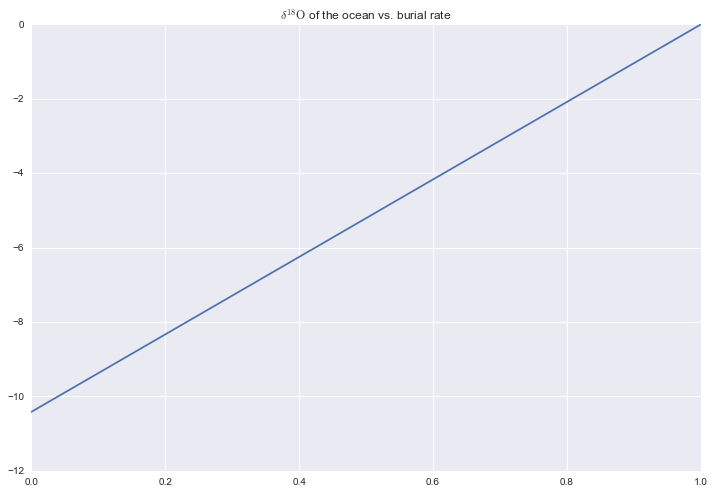

In [44]:
def d13C_by_f_org(f_org):
    """Get equilibrium d13C of atmosphere by burial rate, assuming equilibrium
    between photosynthesis and burial.
    """
    outgas_d = -0.006
    f_carb = 1 - f_org
    return (outgas_d + f_carb * (-0.025)) * 1000
    

def d18O_by_ice_volume(ice_volume):
    """Get equilibrium d13O of atmosphere by burial rate, assuming equilibrium
    between photosynthesis and burial.
    """
    ocean_volume = 1 - ice_volume
    mountain_steps = 50
    init_state = problem23b(mountain_steps, ocean_volume)
    timesteps = 1000
    d_oceans, d_glaciers = problem23c(**init_state)

    return (1-ice_volume) * d_glaciers[-1] * 1000

def problem26():
    benthic = pd.read_csv( os.path.join(dataDir, r'Chapter1Data\marineCores\BenthicTropPacific.txt'),
                          skiprows=40, 
                          delim_whitespace=True)
    d13C = benthic["d13Cforams-b"]
    d13Crange = max(d13C) - min(d13C)
    d13Cstddev = benthic.std(axis=0)["d13Cforams-b"]
    print("d13C varied by {:.2} permil and the stddev was {:.2} permil."
          .format(d13Crange, d13Cstddev))
    burial_space = np.linspace(0, 1, 100)
    d13C_burial = [d13C_by_f_org(r) for r in burial_space]
    plt.figure(figsize=(12, 8))
    plt.title("$\delta^{13}\mathrm{C}$ of carbonates vs. burial rate")
    plt.plot(burial_space, d13C_burial)
    d18O = benthic["d18Oforams-b"]
    d18Orange = max(d18O) - min(d18O)
    d18Ostddev = benthic.std(axis=0)["d18Oforams-b"]
    print("d18O varied by {:.2} permil and the stddev was {:.2} permil."
          .format(d18Orange, d18Ostddev))
    icevol_space = np.linspace(0, 0.999, 50)
    d18O_icevol = [d18O_by_ice_volume(v) for v in icevol_space]
    plt.figure(figsize=(12, 8))
    plt.title("$\delta^{18}\mathrm{O}$ of the ocean vs. burial rate")
    plt.plot(icevol_space, d18O_icevol)
    plt.gca().ticklabel_format(useOffset=False)


problem26()


We see that we would need to vary the burial rate by about 5% of the
total volume of the atmosphere to achieve the maximum variation in
$\delta^{13}\mathrm{C}$ we see historically. We also see that the
higher the burial rate, the higher the $\delta^{13}\mathrm{C}$ of
carbonates. This makes sense as the higher the burial rate, the more
light carbon is taken out of the atmosphere, causing the remaining
carbon to be relatively heavy.

We also see that we would need to vary the fraction of the oceans
locked in ice by almost 20% to achieve the maximum variation in
historical $\delta^{18}\mathrm{O}$. We also see that as more of the
oceans freeze, the oceans have more $\delta^{18}\mathrm{O}$. This
makes sense as glaciers tend to be isotopically lighter than the
oceans.

In an earlier problem we assumed a burial rate of around 1% - this
seems to indicate that a 5% fluctuation is very large, whereas a 20%
fluctuation in the ice volume seems more plausible, and wins my vote for
"more plausible extreme condition."
